In [ ]:
import os
import torch
import torchvision
from torch import nn
from torchvision import transforms

# from sklearn import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import torchmetrics
import mlflow
import random
import tqdm
import cv2

In [3]:
df = pd.read_csv("data\leaf_features.xlsx")
df.head()

,class,image_name,brightness,texture_0,texture_1,texture_2,texture_3,texture_4,texture_5,texture_6,...,hist_54,hist_55,hist_56,hist_57,hist_58,hist_59,hist_60,hist_61,hist_62,hist_63
0,BACT,BACT_0,105.681213,0.000213,179.414974,0.961457,2327.073882,0.162140,211.321734,9128.880553,...,0.002378,0.002118,0.001198,0.001111,0.000486,0.000278,0.000069,0.000017,0.000000,0.0
1,BACT,BACT_1,121.675126,0.000291,248.781522,0.852087,841.118487,0.123878,243.199118,3115.692426,...,0.000260,0.000208,0.000295,0.000313,0.000226,0.000035,0.000052,0.000069,0.000035,0.0
2,BACT,BACT_10,121.750298,0.000424,599.545049,0.892747,2795.011877,0.130888,243.401063,10580.502458,...,0.008003,0.006944,0.006858,0.007014,0.007865,0.007292,0.005226,0.001128,0.000035,0.0
3,BACT,BACT_11,118.741499,0.000262,250.616348,0.954806,2772.998259,0.160693,237.585471,10841.376687,...,0.003212,0.002795,0.001458,0.001233,0.000382,0.000000,0.000000,0.000000,0.000000,0.0
4,BACT,BACT_12,109.830653,0.000250,219.855194,0.958645,2659.035096,0.149557,219.799164,10416.285189,...,0.000451,0.000122,0.000017,0.000017,0.000017,0.000000,0.000000,0.000000,0.000000,0.0


In [4]:
import mahotas

In [5]:
def compute_brightness(img_path):
    img = cv2.imread(img_path)
    if img is None:
        return 0
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return np.mean(gray)


def extract_texture(img_path):
    img = cv2.imread(img_path)
    if img is None:
        return np.zeros(13)
    gray = cv2.cvtColor(cv2.resize(img, (240, 240)), cv2.COLOR_BGR2GRAY)
    return mahotas.features.haralick(gray).mean(axis=0)


def extract_histogram(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(cv2.resize(img, (240, 240)), cv2.COLOR_BGR2GRAY)
    hist = cv2.calcHist([gray], [0], None, [64], [0, 256])
    return hist.flatten() / hist.sum()

In [6]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
from sklearn.preprocessing import StandardScaler

In [7]:
data_dir = "F:\Lettuce_leaf_classification\Lettuce_disease_datasets"
classes = sorted(os.listdir(data_dir))
class_images = {cls: glob(os.path.join(data_dir, cls, "*.jpg")) for cls in classes}
print(classes)

['BACT', 'DML', 'HLTY', 'PML', 'SBL', 'SPW', 'VIRL', 'WLBL']


In [9]:
import os
import pandas as pd
import mahotas

data = []

for label, cls in enumerate(classes):
    for path in class_images[cls][:]:  # Loop over all images for each class
        image_name = os.path.splitext(os.path.basename(path))[
            0
        ]  # Extract image name without extension
        brightness = compute_brightness(path)
        texture = extract_texture(path)
        histogram = extract_histogram(path)

        row = {
            "class": cls,
            "image_name": image_name,
            "brightness": brightness,
        }

        for i, t in enumerate(texture):
            row[f"texture_{i}"] = t

        for i, h in enumerate(histogram):
            row[f"hist_{i}"] = h

        data.append(row)

df_1 = pd.DataFrame(data)
df_1

,class,image_name,brightness,texture_0,texture_1,texture_2,texture_3,texture_4,texture_5,texture_6,...,hist_54,hist_55,hist_56,hist_57,hist_58,hist_59,hist_60,hist_61,hist_62,hist_63
0,BACT,BACT_0,105.681213,0.000213,179.414974,0.961457,2327.073882,0.162140,211.321734,9128.880553,...,0.002378,0.002118,0.001198,0.001111,0.000486,0.000278,0.000069,0.000017,0.0,0.0
1,BACT,BACT_0_aug123,88.295277,0.001049,151.278399,0.968157,2376.693813,0.216847,177.005691,9355.496853,...,0.000017,0.000035,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2,BACT,BACT_0_aug123_aug287,67.870191,0.001271,85.716734,0.969409,1402.435931,0.271734,136.151913,5524.026989,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
3,BACT,BACT_0_aug123_aug287_aug224,68.494489,0.002770,83.977155,0.974685,1659.949657,0.298142,137.425923,6555.821472,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
4,BACT,BACT_0_aug123_aug51,88.760596,0.006908,175.846622,0.969769,2909.561422,0.245007,178.056804,11462.399067,...,0.000608,0.000260,0.000122,0.000035,0.000017,0.000000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16397,WLBL,WLBL_5_aug8_aug93_aug84_aug1166_aug2067,71.854339,0.048899,230.280581,0.971510,4041.782501,0.356626,144.300583,15936.849421,...,0.000469,0.000208,0.000017,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
16398,WLBL,WLBL_5_aug8_aug93_aug84_aug417,62.126874,0.021831,96.525398,0.976201,2028.594608,0.378961,124.548319,8017.853033,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
16399,WLBL,WLBL_5_aug8_aug93_aug84_aug75,62.970498,0.026987,81.244614,0.981918,2247.371154,0.405047,126.009205,8908.240001,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
16400,WLBL,WLBL_5_aug8_aug93_aug84_aug75_aug1123,53.016534,0.027986,44.439837,0.984145,1401.925811,0.469803,106.092712,5563.263405,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0


In [ ]:
df_1.head()
print(df_1.shape)
print(df_1.columns)

(16402, 80)
Index(['class', 'image_name', 'brightness', 'texture_0', 'texture_1',
       'texture_2', 'texture_3', 'texture_4', 'texture_5', 'texture_6',
       'texture_7', 'texture_8', 'texture_9', 'texture_10', 'texture_11',
       'texture_12', 'hist_0', 'hist_1', 'hist_2', 'hist_3', 'hist_4',
       'hist_5', 'hist_6', 'hist_7', 'hist_8', 'hist_9', 'hist_10', 'hist_11',
       'hist_12', 'hist_13', 'hist_14', 'hist_15', 'hist_16', 'hist_17',
       'hist_18', 'hist_19', 'hist_20', 'hist_21', 'hist_22', 'hist_23',
       'hist_24', 'hist_25', 'hist_26', 'hist_27', 'hist_28', 'hist_29',
       'hist_30', 'hist_31', 'hist_32', 'hist_33', 'hist_34', 'hist_35',
       'hist_36', 'hist_37', 'hist_38', 'hist_39', 'hist_40', 'hist_41',
       'hist_42', 'hist_43', 'hist_44', 'hist_45', 'hist_46', 'hist_47',
       'hist_48', 'hist_49', 'hist_50', 'hist_51', 'hist_52', 'hist_53',
       'hist_54', 'hist_55', 'hist_56', 'hist_57', 'hist_58', 'hist_59',
       'hist_60', 'hist_61', 'hist_62'

In [13]:
print(df_1.info())
print(df_1.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16402 entries, 0 to 16401
Data columns (total 80 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   class       16402 non-null  object 
 1   image_name  16402 non-null  object 
 2   brightness  16402 non-null  float64
 3   texture_0   16402 non-null  float64
 4   texture_1   16402 non-null  float64
 5   texture_2   16402 non-null  float64
 6   texture_3   16402 non-null  float64
 7   texture_4   16402 non-null  float64
 8   texture_5   16402 non-null  float64
 9   texture_6   16402 non-null  float64
 10  texture_7   16402 non-null  float64
 11  texture_8   16402 non-null  float64
 12  texture_9   16402 non-null  float64
 13  texture_10  16402 non-null  float64
 14  texture_11  16402 non-null  float64
 15  texture_12  16402 non-null  float64
 16  hist_0      16402 non-null  float32
 17  hist_1      16402 non-null  float32
 18  hist_2      16402 non-null  float32
 19  hist_3      16402 non-nul

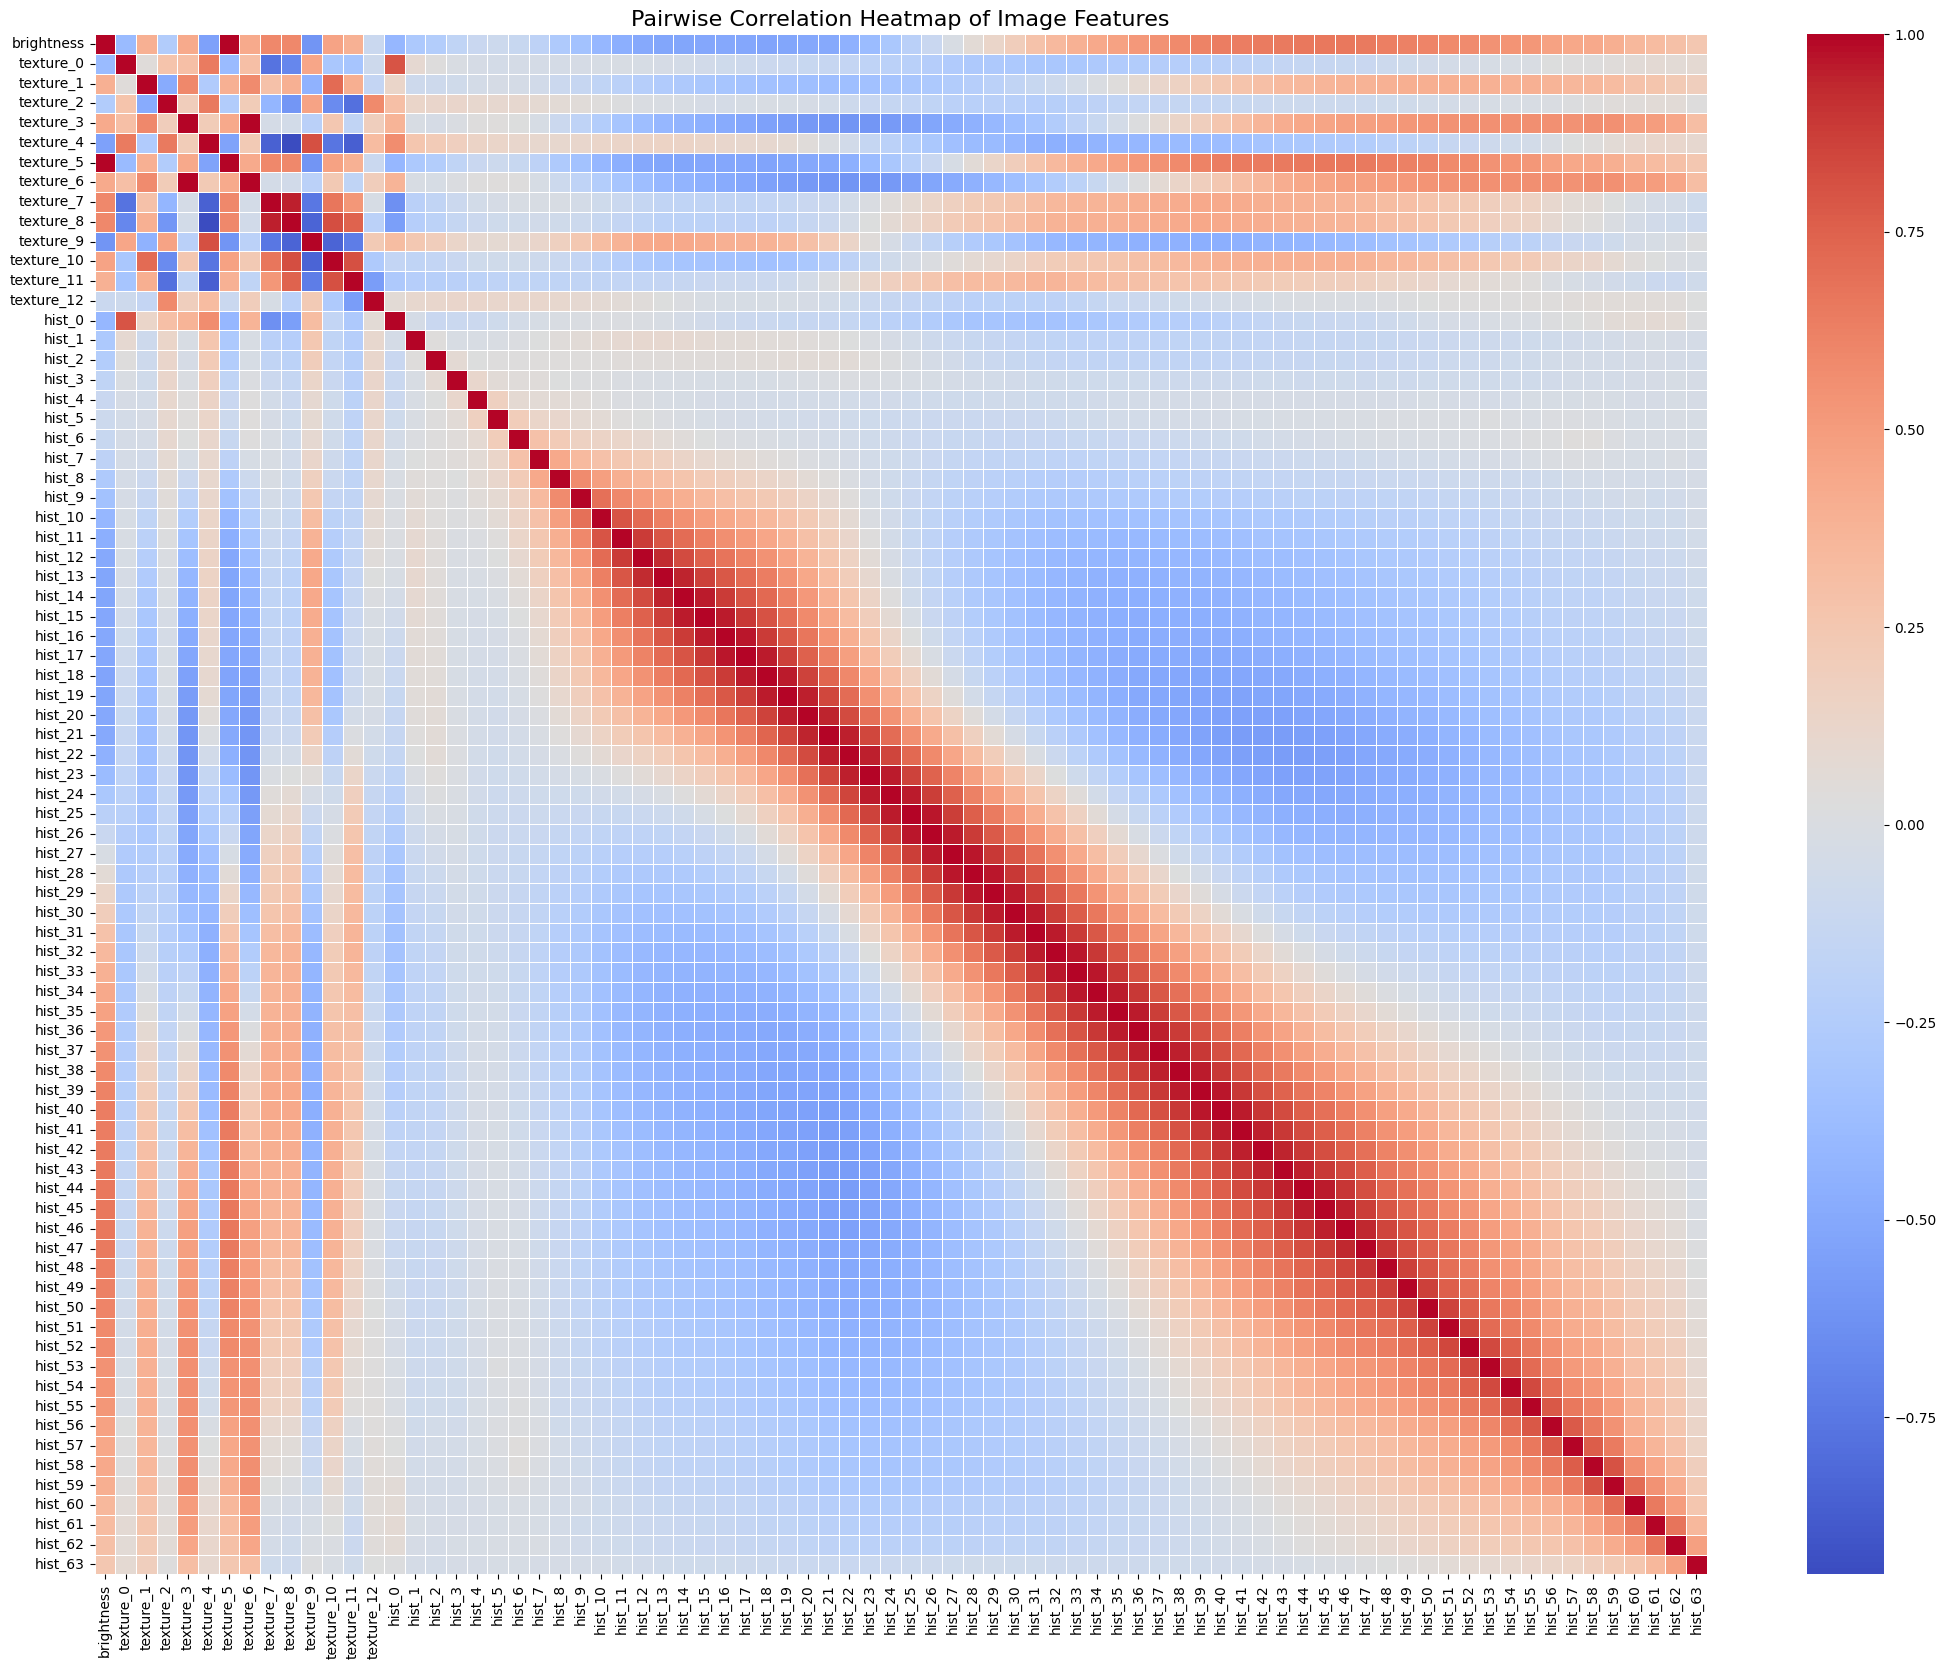

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# we dont need non-numeric or non-feature columns
features_df = df_1.drop(columns=["class", "image_name"])

# Compute correlation matrix
corr_matrix = features_df.corr()

# Plot heatmap
plt.figure(figsize=(26, 20))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Pairwise Correlation Heatmap of Image Features", fontsize=16)
plt.show()

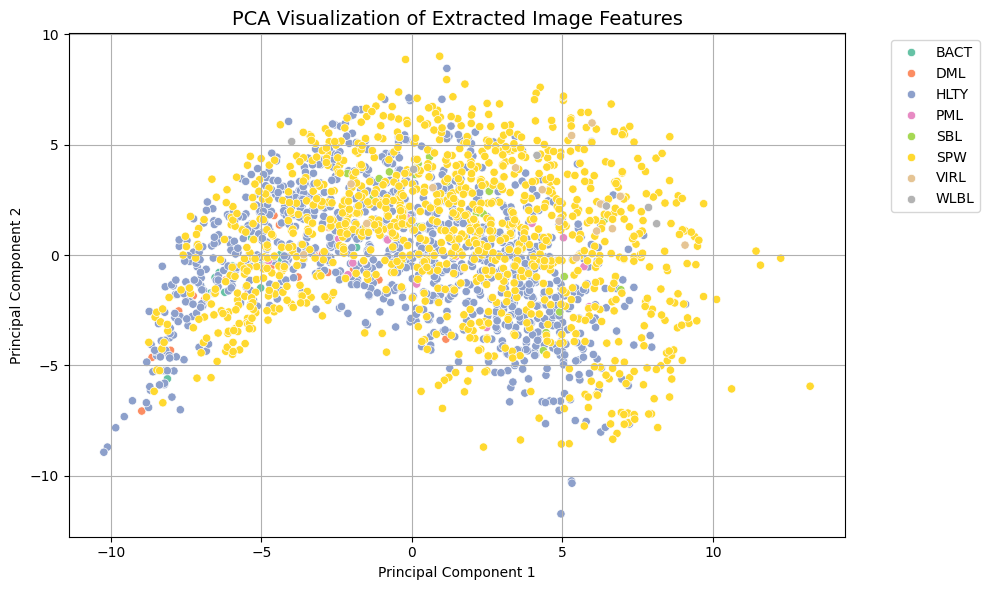

In [16]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Normalize features
X = features_df.values
X_scaled = StandardScaler().fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Add class labels for visualization
df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_pca["class"] = df["class"]

# Plot PCA results
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_pca, x="PC1", y="PC2", hue="class", palette="Set2")
plt.title("PCA Visualization of Extracted Image Features", fontsize=14)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

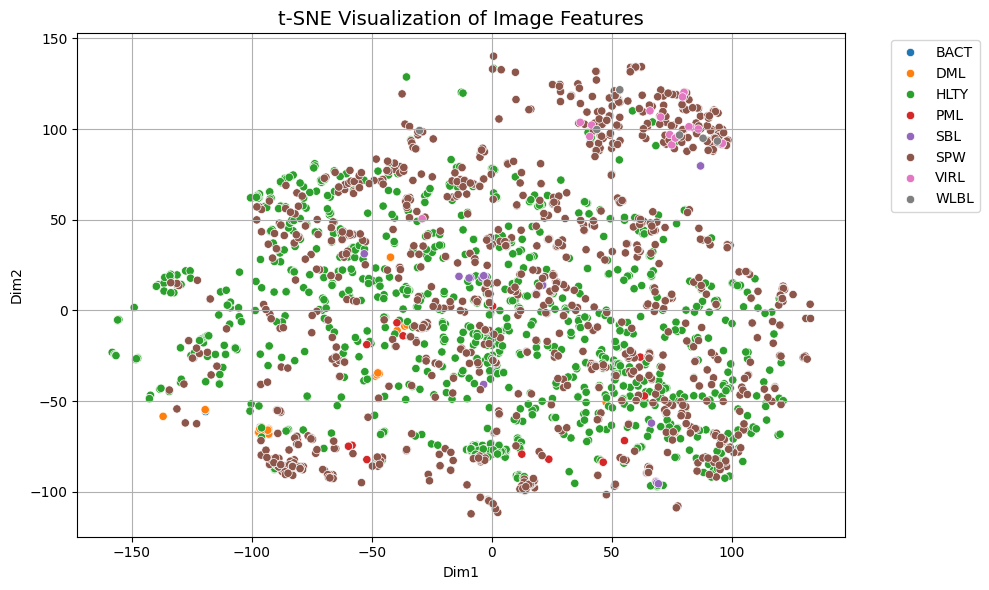

In [17]:
from sklearn.manifold import TSNE

# t-SNE often benefits from PCA pre-processing
pca_50 = PCA(n_components=50)
X_pca_50 = pca_50.fit_transform(X_scaled)


tsne = TSNE(n_components=2, perplexity=30, max_iter=3000, random_state=42)
X_tsne = tsne.fit_transform(X_pca_50)


# Create DataFrame for plotting
df_tsne = pd.DataFrame(X_tsne, columns=["Dim1", "Dim2"])
df_tsne["class"] = df["class"]

# Plot t-SNE
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_tsne, x="Dim1", y="Dim2", hue="class", palette="tab10")
plt.title("t-SNE Visualization of Image Features", fontsize=14)
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [18]:
df.to_csv("data/leaf_aug_features.xlsx", index=False)

In [ ]:
class HybridTinyVGG(nn.Module):
    def __init__(
        self,
        input_shape: int,
        hidden_units: int,
        output_shape: int,
        tabular_input_size: int,
    ):
        super().__init__()

        # CNN branch (same as TinyVGG)
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(input_shape, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # MLP branch for tabular data
        self.tabular_branch = nn.Sequential(
            nn.Linear(tabular_input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
        )

        # Final classifier
        self.classifier = nn.Sequential(
            nn.Linear(
                hidden_units * 16 * 16 + 64, 128
            ),  # image features + tabular features
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, output_shape),
        )

    def forward(self, image, tabular):
        # CNN part
        x = self.conv_block_1(image)
        x = self.conv_block_2(x)
        x = x.view(x.size(0), -1)  # Flatten CNN output

        # Tabular part
        t = self.tabular_branch(tabular)

        # Concatenate
        combined = torch.cat((x, t), dim=1)

        return self.classifier(combined)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch

tabular_df = pd.read_csv("data/leaf_aug_features.xlsx")
tabular_features = tabular_df.drop(["class", "image_name"], axis=1).values
labels = tabular_df["class"].values  # Use the correct column name

# 2. Standardize tabular features
scaler = StandardScaler()
tabular_features = scaler.fit_transform(tabular_features)

# 3. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    tabular_features, labels, test_size=0.25, stratify=labels, random_state=42
)

# 4. Image transforms
img_transforms = transforms.Compose(
    [
        transforms.Resize((64, 64)),  # or (128, 128) as per your model
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [ ]:
class HybridDataset(Dataset):
    def __init__(self, img_paths, tabular_data, labels, transform=None):
        self.img_paths = img_paths
        self.tabular_data = tabular_data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Load image
        img = Image.open(self.img_paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        # Tabular data
        tab = torch.tensor(self.tabular_data[idx], dtype=torch.float32)
        # Label
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return img, tab, label

In [4]:
import os
import pandas as pd
import numpy as np
import torch
from torchvision import models, transforms
from PIL import Image
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score,
)
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.sklearn

# -------------------------- CONFIG -----------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATASET_DIR = "F:/Lettuce_leaf_classification/Lettuce_disease_datasets"
EXTRACTED_FEATURE_CSV = "data\leaf_aug_features.xlsx"
IMG_SIZE = 224
MLFLOW_TRACKING_URI = "http://127.0.0.1:5000"  # Your MLflow server URI

# ---------------------- TRANSFORMS -----------------------------
transform = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

# ---------------------- LOAD PRETRAINED CNN --------------------
resnet = models.resnet18(pretrained=True)
resnet = torch.nn.Sequential(*(list(resnet.children())[:-1]))  # remove final FC
resnet.eval().to(DEVICE)


# ---------------------- FEATURE EXTRACTION ---------------------
def extract_features(dataset_dir, output_csv):
    rows = []
    for label in os.listdir(dataset_dir):
        class_dir = os.path.join(dataset_dir, label)
        if not os.path.isdir(class_dir):
            continue
        for fname in tqdm(os.listdir(class_dir), desc=f"Processing {label}"):
            path = os.path.join(class_dir, fname)
            try:
                img = Image.open(path).convert("RGB")
                tensor = transform(img).unsqueeze(0).to(DEVICE)

                with torch.no_grad():
                    features = resnet(tensor).squeeze().cpu().numpy()

                rows.append(
                    {
                        "image_name": fname,
                        "label": label,
                        **{f"feat_{i}": f for i, f in enumerate(features.flatten())},
                    }
                )
            except Exception as e:
                print(f"Error processing {path}: {e}")

    df = pd.DataFrame(rows)
    df.to_csv(output_csv, index=False)
    print(f"Saved extracted features to {output_csv}")


# ---------------------- TRAINING FUNCTION ----------------------
def train_model(csv_path):
    df = pd.read_csv(csv_path)
    X = df.drop(columns=["image_name", "class"])
    y = df["class"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")
    cm = confusion_matrix(y_test, y_pred)

    return clf, acc, f1, cm, y_test, y_pred


# ------------------ PLOT CONFUSION MATRIX ----------------------
def plot_confusion_matrix(cm, class_names, save_path="confusion_matrix.png"):
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names
    )
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()


# ----------------------- MLFLOW LOGGER -------------------------
def log_with_mlflow(
    model, acc, f1, cm, y_true, y_pred, artifact_path="confusion_matrix.png"
):
    mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
    mlflow.set_experiment("Lettuce_Classification")

    with mlflow.start_run():
        mlflow.log_metric("accuracy", acc)
        mlflow.log_metric("f1_score", f1)

        plot_confusion_matrix(
            cm, class_names=sorted(set(y_true)), save_path=artifact_path
        )
        mlflow.log_artifact(artifact_path)

        mlflow.sklearn.log_model(model, "random_forest_model")


# --------------------------- MAIN ------------------------------
if __name__ == "__main__":
    if not os.path.exists(EXTRACTED_FEATURE_CSV):
        extract_features(DATASET_DIR, EXTRACTED_FEATURE_CSV)

    model, acc, f1, cm, y_true, y_pred = train_model(EXTRACTED_FEATURE_CSV)
    log_with_mlflow(model, acc, f1, cm, y_true, y_pred)

    print(f"Training complete. Accuracy: {acc:.4f}, F1-score: {f1:.4f}")

f:\Lettuce_leaf_classification\Lettuce_leaf_classification\leaf_classf\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
f:\Lettuce_leaf_classification\Lettuce_leaf_classification\leaf_classf\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
2025/08/07 20:19:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/07 20:19:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto inf

🏃 View run charming-duck-991 at: http://127.0.0.1:5000/#/experiments/570064072894460474/runs/89613c977bdf441a9b930f3bdc5a3f32
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/570064072894460474
Training complete. Accuracy: 0.9530, F1-score: 0.9421
